# Fruit-360 Dataset Classification

The goal is to use CNN to classify images from the dataset.

First, import the packages needed for the task.

## Downloading Data

Check the directories to make sure the dataset is in the correct folder.

In [1]:
import os
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
os.environ['KAGGLE_CONFIG_DIR'] = '/content'
!kaggle datasets download -d moltean/fruits

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘/root/.kaggle’: File exists
fruits.zip: Skipping, found more recently modified local copy (use --force to force download)


In [2]:
import zipfile
zip = '/content/fruits.zip'
ref = zipfile.ZipFile(zip, 'r')
ref.extractall('/content')
ref.close()

## Organizing Data

In [3]:
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator, img_to_array
from tensorflow.keras import layers, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, GlobalAvgPool2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import random

Use the fruit-360_dataset as the dataset, then set the train and test directories.

In [4]:
# Directory with all files
base_dir = '/content/fruits-360_dataset/fruits-360'

# Directory with training and testing images
train_dir = os.path.join(base_dir, 'Training')
test_dir = os.path.join(base_dir, 'Test')

train_dir_sorted = os.listdir(train_dir)
train_dir_sorted = np.sort(train_dir_sorted)

test_dir_sorted = os.listdir(test_dir)
test_dir_sorted = np.sort(test_dir_sorted)

Creat 3 lists, one storing the labels of the training set, one storing the images of the training set, and one storing the classes of the training set. The list stroing the class is only used to count the number of total classes in the dataset.

In [5]:
training_fruit_labels = [] # labels
training_fruit_images = [] # images
classes = [] # classes
for fruit_name in train_dir_sorted:
    classes.append(fruit_name)
    for image_filename in os.listdir(train_dir + '/' + fruit_name):
        training_fruit_labels.append(fruit_name) # name of the fruit 
        training_fruit_images.append(fruit_name + '/' + image_filename) # image of the fruit

Check if the number of data collected matches the description of the dataset: 67692 images in the training set and 131 classes.

In [6]:
print('Total training images:', len(training_fruit_images))
print('Total classes:', len(classes))

Total training images: 67692
Total classes: 131


Organize a dataframe with pandas to visualise the training data.

In [7]:
train_fruits = pd.DataFrame(training_fruit_labels, columns = ["Train Fruits"])
train_fruits["Fruits Image"] = training_fruit_images
train_fruits.index += 1
train_fruits

,Train Fruits,Fruits Image
1,Apple Braeburn,Apple Braeburn/r_135_100.jpg
2,Apple Braeburn,Apple Braeburn/r_159_100.jpg
3,Apple Braeburn,Apple Braeburn/r_138_100.jpg
4,Apple Braeburn,Apple Braeburn/168_100.jpg
5,Apple Braeburn,Apple Braeburn/142_100.jpg
...,...,...
67688,Watermelon,Watermelon/r_136_100.jpg
67689,Watermelon,Watermelon/195_100.jpg
67690,Watermelon,Watermelon/163_100.jpg
67691,Watermelon,Watermelon/118_100.jpg


Do the same for the testing data.

In [8]:
label_test = [] # labels
image_test = [] # images
for fruit_name in test_dir_sorted:
    for image_filename in os.listdir(test_dir + '/' + fruit_name):
        label_test.append(fruit_name) # name of the fruit 
        image_test.append(fruit_name + '/' + image_filename) # image of the fruit

test_fruits = pd.DataFrame(label_test, columns = ["Test Fruits"])
test_fruits["Fruits Image"] = image_test
test_fruits.index += 1
test_fruits

,Test Fruits,Fruits Image
1,Apple Braeburn,Apple Braeburn/r_322_100.jpg
2,Apple Braeburn,Apple Braeburn/42_100.jpg
3,Apple Braeburn,Apple Braeburn/79_100.jpg
4,Apple Braeburn,Apple Braeburn/r_50_100.jpg
5,Apple Braeburn,Apple Braeburn/98_100.jpg
...,...,...
22684,Watermelon,Watermelon/r_64_100.jpg
22685,Watermelon,Watermelon/r_86_100.jpg
22686,Watermelon,Watermelon/131_100.jpg
22687,Watermelon,Watermelon/276_100.jpg


Display the first image to get a sense of what the training images looks like. It consists of 1 image and 1 label.

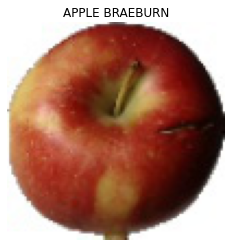

In [9]:
img = load_img(train_dir + '/' + train_fruits["Fruits Image"][1])
plt.title(train_fruits["Train Fruits"][1].upper())
plt.imshow(img)
plt.axis("off")
plt.show()

## Visualizing Data Distribution

In [10]:
train_class_number = []
for fruit_name in train_dir_sorted:
    count = 0
    for image_filename in os.listdir(os.path.join(train_dir, fruit_name)):
        count += 1
    train_class_number.append(count)

train_distribution = pd.DataFrame(classes, columns = ["Fruit"])
train_distribution["Number"] = train_class_number
train_distribution.index += 1
train_distribution

,Fruit,Number
1,Apple Braeburn,492
2,Apple Crimson Snow,444
3,Apple Golden 1,480
4,Apple Golden 2,492
5,Apple Golden 3,481
...,...,...
127,Tomato Maroon,367
128,Tomato Yellow,459
129,Tomato not Ripened,474
130,Walnut,735


In [11]:
train_distribution = train_distribution.sort_values(by=['Number'], ascending=False)

In [12]:
test_class_number = []
for fruit_name in test_dir_sorted:
    count = 0
    for image_filename in os.listdir(test_dir + '/' + fruit_name):
        count += 1
    test_class_number.append(count)

test_distribution = pd.DataFrame(classes, columns = ["Fruit"])
test_distribution["Number"] = test_class_number
test_distribution.index += 1
test_distribution

,Fruit,Number
1,Apple Braeburn,164
2,Apple Crimson Snow,148
3,Apple Golden 1,160
4,Apple Golden 2,164
5,Apple Golden 3,161
...,...,...
127,Tomato Maroon,127
128,Tomato Yellow,153
129,Tomato not Ripened,158
130,Walnut,249


In [13]:
test_distribution = test_distribution.sort_values(by=['Number'], ascending=False)

In [14]:
train_distribution

,Fruit,Number
45,Grape Blue,984
105,Plum 3,900
82,Peach 2,738
118,Strawberry Wedge,738
121,Tomato 1,738
...,...,...
38,Cucumber Ripe,392
127,Tomato Maroon,367
88,Pear Kaiser,300
67,Mangostan,300


In [15]:
test_distribution

,Fruit,Number
45,Grape Blue,328
105,Plum 3,304
130,Walnut,249
123,Tomato 3,246
28,Cherry 2,246
...,...,...
38,Cucumber Ripe,130
127,Tomato Maroon,127
88,Pear Kaiser,102
67,Mangostan,102


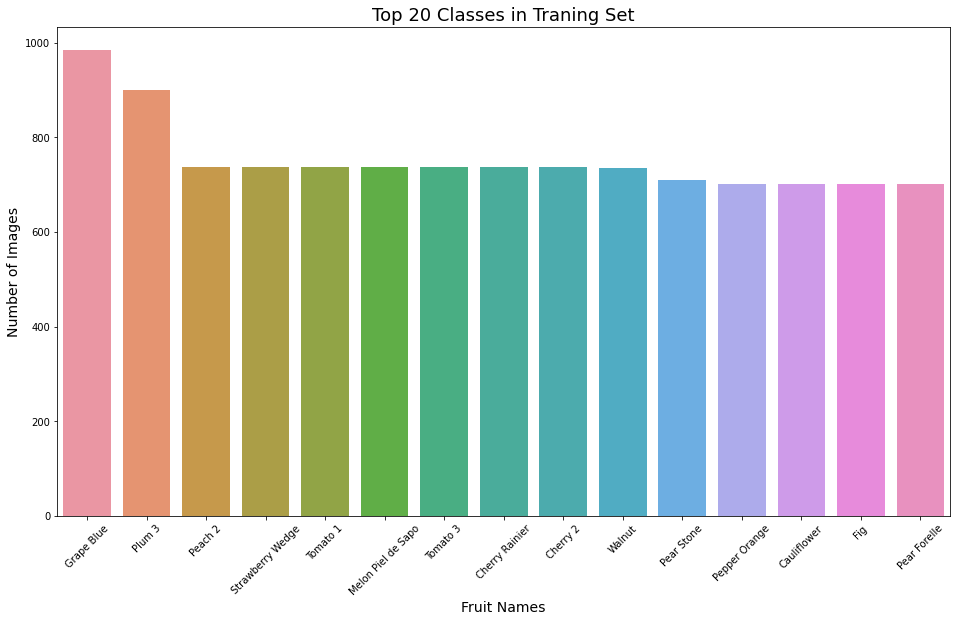

In [16]:
plt.figure(figsize=(16,9))
ax = sns.barplot(x = train_distribution['Fruit'][:15], y = train_distribution['Number'][:15])
ax.set_title('Top 20 Classes in Traning Set', fontsize=18)
ax.set_xlabel('Fruit Names', fontsize=14)
ax.set_ylabel('Number of Images', fontsize=14)

ax.xaxis.set_ticklabels(train_distribution['Fruit'][:15], rotation = 45)

plt.show()

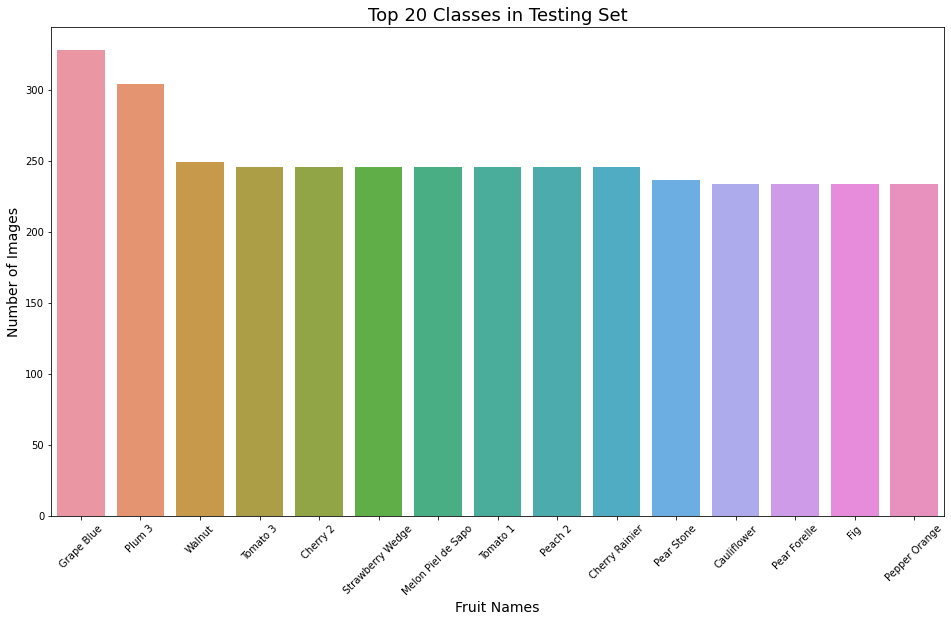

In [17]:
plt.figure(figsize=(16,9))
ax = sns.barplot(x = test_distribution['Fruit'][:15], y = test_distribution['Number'][:15])
ax.set_title('Top 20 Classes in Testing Set', fontsize=18)
ax.set_xlabel('Fruit Names', fontsize=14)
ax.set_ylabel('Number of Images', fontsize=14)

ax.xaxis.set_ticklabels(test_distribution['Fruit'][:15], rotation = 45)

plt.show()

## Preprocessing

In [18]:
# rescale imgae by 1./255 to keep all values in [0,1] since RGB values range from 0 to 255
train_data_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split = 0.2) # split 0.2 of the input for validation
test_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input)

# training
train_generator = train_data_generator.flow_from_directory(
        train_dir, # directory of training images
        target_size = (100, 100), # resize image to 100x100
        shuffle = True,
        batch_size = 128,
        subset = 'training', # identify as training generator
        class_mode= 'categorical')

# validation
validation_generator = train_data_generator.flow_from_directory(
        train_dir, # directory of training images
        target_size = (100, 100),
        shuffle = True,
        batch_size = 128,
        subset = 'validation', # identify as validation generator
        class_mode= 'categorical')

# testing
test_generator = test_data_generator.flow_from_directory(
        test_dir, # directory of testing images
        target_size = (100, 100),
        shuffle = False, # disable shuffle
        batch_size = 64,
        class_mode = 'categorical')

Found 54190 images belonging to 131 classes.
Found 13502 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


Tell the model when to stop when calidation loss stop decrease for 3 consecutive times.

In [19]:
# callback used to stop the training early depending on validation loss
# restore the best weights
callback = EarlyStopping(
    monitor = 'val_accuracy',
    mode = 'max',
    min_delta = 0.01,
    patience = 4,
    restore_best_weights = True)

In [20]:
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.1,
    patience = 2,
    min_lr = 0.00001)

## SC-3

In [21]:
# define model
sc3 = Sequential()

# input is 100x10x3: 100x100 pixels, and 3 for RGB
# first convolution layer extracts 32 3x3 filters
# then apply a 2x2 max-pooling layer
sc3.add(Conv2D(filters = 32, kernel_size = 3, input_shape = (100, 100, 3), activation = 'relu'))
sc3.add(MaxPool2D(2))

# second convolution layer extracts 32 3x3 filters
# then apply a 2x2 max-pooling layer
sc3.add(Conv2D(filters = 32, kernel_size = 3, activation = 'relu'))
sc3.add(MaxPool2D(2))

# third convolution layer extracts 64 3x3 filters
# then apply a 2x2 max-pooling layer
sc3.add(Conv2D(filters = 64, kernel_size = 3, activation = 'relu'))
sc3.add(MaxPool2D(2))

# flatten to a 1-dim tensor (vector)
sc3.add(Flatten())

# create a dense layer with ReLU activation and 1024 hidden units
#sc3.add(Dense(units = 512, activation = 'relu'))

# create a dropout layer to prevent overfitting
sc3.add(Dropout(0.5))

# create output layer with 131 units and softmax activation for multiclass classification
sc3.add(Dense(units = 131, kernel_regularizer='l2', activation = 'softmax'))

sc3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 10, 10, 64)       0

In [22]:
sc3.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])

## VGG-16

In [23]:
vgg16_model = VGG16(include_top = False, weights = 'imagenet', input_shape = (100, 100, 3), classes = 131)
vgg = Sequential()

for layer in vgg16_model.layers[:-2]:
  layer.trainable=False

vgg.add(vgg16_model)

vgg.add(Flatten())
vgg.add(Dropout(0.5))
vgg.add(Dense(units = 131, kernel_regularizer='l2', activation = 'softmax'))

vgg.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 4608)              0         
                                                                 
 dropout_1 (Dropout)         (None, 4608)              0         
                                                                 
 dense_1 (Dense)             (None, 131)               603779    
                                                                 
Total params: 15,318,467
Trainable params: 2,963,587
Non-trainable params: 12,354,880
_________________________________________________________________


In [24]:
vgg.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])

## ResNet-50

In [25]:
resnet50_model = ResNet50(include_top=False, weights='imagenet', input_shape=(100,100,3), classes=131)

res = Sequential()
res.add(resnet50_model)
res.add(GlobalAvgPool2D())
#res.add(Dense(units=512, activation='relu'))
res.add(Dropout(0.5))
res.add(Dense(units=131, kernel_regularizer='l2', activation='softmax'))
res.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 131)               268419    
                                                                 
Total params: 23,856,131
Trainable params: 23,803,011
Non-trainable params: 53,120
_________________________________________________________________


In [26]:
res.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])

## MobileNet

In [27]:
mobile_net1 = MobileNet()
mobile_net = Sequential()

for layer in mobile_net1.layers[:-1]:
  mobile_net.add(layer)

mobile_net.add(Dropout(rate=0.5))
mobile_net.add(Dense(units = 131, kernel_regularizer='l2', activation = 'softmax'))

mobile_net.summary()

17235968/17225924 [==============================] - 0s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                          
                                                       

In [28]:
mobile_net.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])

## Fitting

Fit the model using data from *train_generator*, train for 15 epochs, stop when validation accuracy did not improve in 3 epochs.

In [29]:
hist_sc3 = sc3.fit(
    train_generator,
    epochs = 25,
    validation_data = validation_generator,
    callbacks = [callback, reduce_lr])

Epoch 1/25
424/424 [==============================] - 171s 399ms/step - loss: 2.3427 - accuracy: 0.5608 - val_loss: 1.5395 - val_accuracy: 0.7525 - lr: 0.0010
Epoch 2/25
424/424 [==============================] - 167s 394ms/step - loss: 1.2605 - accuracy: 0.8035 - val_loss: 1.1771 - val_accuracy: 0.8122 - lr: 0.0010
Epoch 3/25
424/424 [==============================] - 166s 392ms/step - loss: 1.0670 - accuracy: 0.8431 - val_loss: 1.0088 - val_accuracy: 0.8645 - lr: 0.0010
Epoch 4/25
424/424 [==============================] - 166s 391ms/step - loss: 0.9683 - accuracy: 0.8651 - val_loss: 0.9356 - val_accuracy: 0.8757 - lr: 0.0010
Epoch 5/25
424/424 [==============================] - 166s 391ms/step - loss: 0.9038 - accuracy: 0.8768 - val_loss: 0.8886 - val_accuracy: 0.8862 - lr: 0.0010
Epoch 6/25
424/424 [==============================] - 166s 391ms/step - loss: 0.8685 - accuracy: 0.8839 - val_loss: 0.8999 - val_accuracy: 0.8771 - lr: 0.0010
Epoch 7/25
424/424 [==========================

In [30]:
hist_vgg = vgg.fit(
    train_generator,
    epochs = 25,
    validation_data = validation_generator,
    callbacks = [callback, reduce_lr])

Epoch 1/25
424/424 [==============================] - 171s 399ms/step - loss: 1.6891 - accuracy: 0.7532 - val_loss: 0.7661 - val_accuracy: 0.9125 - lr: 0.0010
Epoch 2/25
424/424 [==============================] - 169s 399ms/step - loss: 0.6615 - accuracy: 0.9192 - val_loss: 0.6183 - val_accuracy: 0.9228 - lr: 0.0010
Epoch 3/25
424/424 [==============================] - 169s 399ms/step - loss: 0.5515 - accuracy: 0.9364 - val_loss: 0.5464 - val_accuracy: 0.9342 - lr: 0.0010
Epoch 4/25
424/424 [==============================] - 168s 396ms/step - loss: 0.4998 - accuracy: 0.9464 - val_loss: 0.5368 - val_accuracy: 0.9330 - lr: 0.0010
Epoch 5/25
424/424 [==============================] - 168s 397ms/step - loss: 0.4889 - accuracy: 0.9478 - val_loss: 0.5171 - val_accuracy: 0.9445 - lr: 0.0010
Epoch 6/25
424/424 [==============================] - 168s 397ms/step - loss: 0.4594 - accuracy: 0.9530 - val_loss: 0.4882 - val_accuracy: 0.9443 - lr: 0.0010
Epoch 7/25
424/424 [==========================

In [31]:
hist_res = res.fit(
    train_generator,
    epochs = 25,
    validation_data = validation_generator,
    callbacks = [callback, reduce_lr])

Epoch 1/25
424/424 [==============================] - 178s 407ms/step - loss: 1.0442 - accuracy: 0.8939 - val_loss: 12.1210 - val_accuracy: 0.0068 - lr: 0.0010
Epoch 2/25
424/424 [==============================] - 171s 404ms/step - loss: 0.2303 - accuracy: 0.9744 - val_loss: 3.4141 - val_accuracy: 0.4171 - lr: 0.0010
Epoch 3/25
424/424 [==============================] - 172s 405ms/step - loss: 0.2150 - accuracy: 0.9740 - val_loss: 0.8762 - val_accuracy: 0.8577 - lr: 0.0010
Epoch 4/25
424/424 [==============================] - 172s 405ms/step - loss: 0.1894 - accuracy: 0.9782 - val_loss: 0.9927 - val_accuracy: 0.8139 - lr: 0.0010
Epoch 5/25
424/424 [==============================] - 172s 404ms/step - loss: 0.1603 - accuracy: 0.9832 - val_loss: 0.6525 - val_accuracy: 0.8754 - lr: 0.0010
Epoch 6/25
424/424 [==============================] - 171s 404ms/step - loss: 0.1342 - accuracy: 0.9866 - val_loss: 1.1316 - val_accuracy: 0.7898 - lr: 0.0010
Epoch 7/25
424/424 [=========================

In [32]:
# fitting model
hist_mobile = mobile_net.fit(
    train_generator,
    epochs = 25,
    validation_data = validation_generator,
    callbacks = [callback, reduce_lr])

Epoch 1/25
424/424 [==============================] - 172s 399ms/step - loss: 2.5196 - accuracy: 0.8514 - val_loss: 1.1916 - val_accuracy: 0.9167 - lr: 0.0010
Epoch 2/25
424/424 [==============================] - 168s 397ms/step - loss: 0.5707 - accuracy: 0.9835 - val_loss: 0.3435 - val_accuracy: 0.9742 - lr: 0.0010
Epoch 3/25
424/424 [==============================] - 168s 395ms/step - loss: 0.1625 - accuracy: 0.9947 - val_loss: 0.2175 - val_accuracy: 0.9636 - lr: 0.0010
Epoch 4/25
424/424 [==============================] - 168s 396ms/step - loss: 0.1446 - accuracy: 0.9872 - val_loss: 0.8842 - val_accuracy: 0.8242 - lr: 0.0010
Epoch 5/25
424/424 [==============================] - 168s 396ms/step - loss: 0.2958 - accuracy: 0.9725 - val_loss: 1.0613 - val_accuracy: 0.8571 - lr: 0.0010
Epoch 6/25
424/424 [==============================] - 169s 398ms/step - loss: 0.1872 - accuracy: 0.9966 - val_loss: 0.1873 - val_accuracy: 0.9919 - lr: 1.0000e-04
Epoch 7/25
424/424 [======================

## Predicting

Make a prediction using the trained model on the *test_generator*, and record the output vectors.

In [33]:
# record the output vectors containing the probability of each class
pred_sc3 = sc3.predict(test_generator)
pred_vgg = vgg.predict(test_generator)
pred_res = res.predict(test_generator)
pred_mobile = mobile_net.predict(test_generator)

Evaluate the loss and accuracy of the model on *train_generator*.

In [34]:
# record the loss and accuracy of the prediction
pred_loss_acc_sc3 = sc3.evaluate(test_generator)
pred_loss_acc_vgg = vgg.evaluate(test_generator)
pred_loss_acc_res = res.evaluate(test_generator)
pred_loss_acc_mobile = mobile_net.evaluate(test_generator)

355/355 [==============================] - 12s 34ms/step - loss: 0.2172 - accuracy: 0.9844


Output the loss and accuracy of the prediction.

In [35]:
print(('SC-3: Loss: {}\tAccuracy: {}%').format(round(pred_loss_acc_sc3[0], 2), round(100 * pred_loss_acc_sc3[1], 2)))
print(('VGG-16: Loss: {}\tAccuracy: {}%').format(round(pred_loss_acc_vgg[0], 2), round(100 * pred_loss_acc_vgg[1], 2)))
print(('ResNet-50: Loss: {}\tAccuracy: {}%').format(round(pred_loss_acc_res[0], 2), round(100 * pred_loss_acc_res[1], 2)))
print(('MobileNet: Loss: {}\tAccuracy: {}%').format(round(pred_loss_acc_mobile[0], 2), round(100 * pred_loss_acc_mobile[1], 2)))

SC-3: Loss: 0.46	Accuracy: 97.1%
VGG-16: Loss: 0.55	Accuracy: 93.17%
ResNet-50: Loss: 0.09	Accuracy: 99.31%
MobileNet: Loss: 0.22	Accuracy: 98.44%


## Visualization

In [36]:
accuracy = [round(pred_loss_acc_sc3[1], 2), round(pred_loss_acc_vgg[1], 2), round(pred_loss_acc_res[1], 2), round(pred_loss_acc_mobile[1], 2)]
model_name = ['SC-3', 'VGG-16', 'ResNet-50', 'MobileNet']

df = pd.DataFrame({"Accuracy":accuracy, "Model":model_name})

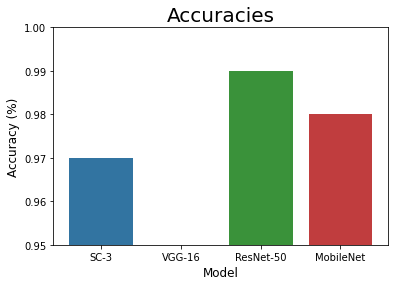

In [37]:
plt.figure()

splot = sns.barplot(y = 'Accuracy', x = 'Model', data=df)
plt.title('Accuracies', fontsize = 20)
plt.ylabel('Accuracy (%)', fontsize = 12)
plt.xlabel('Model', fontsize = 12)

plt.axis([-0.6, 3.6, 0.95, 1])
plt.show()

Retrive the metrics and plot the accuracy and loss graphs.

ValueError: ignored

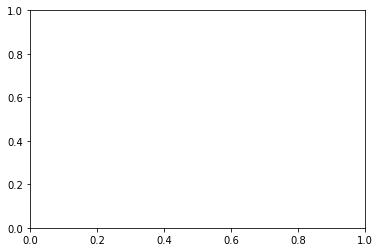

In [38]:
# retrieve results on training and validation data
sc3_acc = hist_sc3.history['accuracy']
sc3_val_acc = hist_sc3.history['val_accuracy']

vgg_acc = hist_vgg.history['accuracy']
vgg_val_acc = hist_vgg.history['val_accuracy']

res_acc = hist_res.history['accuracy']
res_val_acc = hist_res.history['val_accuracy']

mobile_acc = hist_mobile.history['accuracy']
mobile_val_acc = hist_mobile.history['val_accuracy']

# loss
sc3_loss = hist_sc3.history['loss']
sc3_val_loss = hist_sc3.history['val_loss']

vgg_loss = hist_vgg.history['loss']
vgg_val_loss = hist_vgg.history['val_loss']

res_loss = hist_res.history['loss']
res_val_loss = hist_res.history['val_loss']

mobile_loss = hist_mobile.history['loss']
mobile_val_loss = hist_mobile.history['val_loss']

# number of epochs
a = len(sc3_acc)
b = len(vgg_acc)
c = len(res_acc)
d = len(mobile_acc)
#print(max(a,b,c,d))
epochs = range(14)

# plot training and validation accuracy per epoch
plt.plot(epochs, sc3_acc, label = 'sc_acc')
plt.plot(vgg_acc, label = 'vgg_acc')
plt.plot(res_acc, label = 'res_acc')
plt.plot(mobile_acc, label = 'mobile_acc')
plt.title('Training Accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, sc3_val_acc, label = 'sc_val_acc')
plt.plot(vgg_val_acc, label = 'vgg_val_acc')
plt.plot(res_val_acc, label = 'res_val_acc')
plt.plot(mobile_val_acc, label = 'mobile_val_acc')
plt.title('Validation Accuracy')
plt.legend()

# plot training and validation loss per epoch
plt.figure()
plt.plot(epochs, sc3_loss, label = 'sc3_loss')
plt.plot(vgg_loss, label = 'vgg_loss')
plt.plot(res_loss, label = 'res_loss')
plt.plot(mobile_loss, label = 'mobile_loss')
plt.title('Training Loss')
plt.legend()

plt.figure()
plt.plot(epochs, sc3_val_loss, label = 'sc3_val_loss')
plt.plot(vgg_val_loss, label = 'vgg_val_loss')
plt.plot(res_val_loss, label = 'res_val_loss')
plt.plot(mobile_val_loss, label = 'mobile_val_loss')
plt.title('Validation Loss')
plt.legend()

The vectors in *pred* represent the probability of each class, take the one with the highest probability.

In [ ]:
# get the index of the highest probable classes
predict_class_index_sc3 = [np.argmax(element) for element in pred_sc3]
predict_class_index_vgg = [np.argmax(element) for element in pred_vgg]
predict_class_index_res = [np.argmax(element) for element in pred_res]
predict_class_index_mobile = [np.argmax(element) for element in pred_mobile]

# convert index to string classes
predict_classes_sc3 = [classes[i] for i in predict_class_index_sc3]
predict_classes_vgg = [classes[i] for i in predict_class_index_vgg]
predict_classes_res = [classes[i] for i in predict_class_index_res]
predict_classes_mobile = [classes[i] for i in predict_class_index_mobile]

Compute the Confusion Matrix for Visualization

In [ ]:
# compute the confusion matrix using prediction and testing labels
cf_matrix_sc3 = confusion_matrix(predict_classes_sc3, label_test)
cf_matrix_vgg = confusion_matrix(predict_classes_vgg, label_test)
cf_matrix_res = confusion_matrix(predict_classes_res, label_test)
cf_matrix_mobile = confusion_matrix(predict_classes_mobile, label_test)

In [ ]:
# compute the percentage of accuracy for each class in the confusion matrix
cf_matrix_percentage_sc3 = cf_matrix_sc3 / np.sum(cf_matrix_sc3, axis=0)
cf_matrix_percentage_vgg = cf_matrix_vgg / np.sum(cf_matrix_vgg, axis=0)
cf_matrix_percentage_res = cf_matrix_res / np.sum(cf_matrix_res, axis=0)
cf_matrix_percentage_mobile = cf_matrix_mobile / np.sum(cf_matrix_mobile, axis=0)

A smaller confusion matrix that is part of the larger one.

In [ ]:
# plot the small confusion matrix
ax = sns.heatmap(cf_matrix_percentage_sc3[35:40,35:40], annot = True, fmt = '.2%', cmap = 'Blues')

ax.set_title('Fruit-360 First 5 Classes Confusion Matrix SC-3\n')
ax.set_xlabel('Predicted Fruit')
ax.set_ylabel('Actual Fruit')

# labels of the first 5 classes rotated 45 degrees
ax.xaxis.set_ticklabels(classes[35:40], rotation = 45)
ax.yaxis.set_ticklabels(classes[35:40], rotation = 45)

plt.show()

In [ ]:
# plot the small confusion matrix
ax = sns.heatmap(cf_matrix_percentage_vgg[35:40,35:40], annot = True, fmt = '.2%', cmap = 'Blues')

ax.set_title('Fruit-360 First 5 Classes Confusion Matrix VGG-16\n')
ax.set_xlabel('Predicted Fruit')
ax.set_ylabel('Actual Fruit')

# labels of the first 5 classes rotated 45 degrees
ax.xaxis.set_ticklabels(classes[35:40], rotation = 45)
ax.yaxis.set_ticklabels(classes[35:40], rotation = 45)

plt.show()

In [ ]:
# plot the small confusion matrix
ax = sns.heatmap(cf_matrix_percentage_res[35:40,35:40], annot = True, fmt = '.2%', cmap = 'Blues')

ax.set_title('Fruit-360 First 5 Classes Confusion Matrix ResNet-50\n')
ax.set_xlabel('Predicted Fruit')
ax.set_ylabel('Actual Fruit')

# labels of the first 5 classes rotated 45 degrees
ax.xaxis.set_ticklabels(classes[35:40], rotation = 45)
ax.yaxis.set_ticklabels(classes[35:40], rotation = 45)

plt.show()

In [ ]:
# plot the small confusion matrix
ax = sns.heatmap(cf_matrix_percentage_mobile[35:40,35:40], annot = True, fmt = '.2%', cmap = 'Blues')

ax.set_title('Fruit-360 First 5 Classes Confusion Matrix MobileNet\n')
ax.set_xlabel('Predicted Fruit')
ax.set_ylabel('Actual Fruit')

# labels of the first 5 classes rotated 45 degrees
ax.xaxis.set_ticklabels(classes[35:40], rotation = 45)
ax.yaxis.set_ticklabels(classes[35:40], rotation = 45)

plt.show()

In [ ]:
# function that shows the percentage distribution of predictions for a certain class
def vis_spread(name, cf_matrix_percentage):
    error_classes = []
    error_percentage = []
    index = classes.index(name) # get the index of the input fruit
    for i in range(len(classes)):
        if cf_matrix_percentage[i,index] != 0:
            error_classes.append(classes[i])
            error_percentage.append(round(cf_matrix_percentage[i,index] * 100, 2))
    
    error_classes = np.asarray(error_classes)
    error_percentage = np.asarray(error_percentage)
    index_desc = np.flip(np.argsort(error_percentage))
    error = pd.DataFrame(error_classes[index_desc], columns = ['Classes'])
    error[' Percentage'] = error_percentage[index_desc]
    error.index += 1
    print(error)

In [ ]:
vis_spread('Corn', cf_matrix_percentage_sc3)

In [ ]:
vis_spread('Corn', cf_matrix_percentage_vgg)

In [ ]:
vis_spread('Corn', cf_matrix_percentage_res)

In [ ]:
vis_spread('Corn', cf_matrix_percentage_mobile)

In [ ]:
vis_spread('Corn Husk', cf_matrix_percentage_sc3)
vis_spread('Corn Husk', cf_matrix_percentage_vgg)
vis_spread('Corn Husk', cf_matrix_percentage_res)
vis_spread('Corn Husk', cf_matrix_percentage_mobile)

In [ ]:
# function that plots 15 random fruits with prediction and actual label
def plot_random(predict_classes):
    plt.figure(figsize=(16,9))
    sample_num = len(label_test)
    title = 'Predicted: {}\nActual: {}'
    for i in range(15):
        x = random.randint(0, sample_num)
        plt.subplot(3,5,i+1)
        img = load_img(test_dir + '/' + image_test[x])
        plt.imshow(img)
        plt.title(title.format(predict_classes[x], label_test[x]))
        plt.axis("off")

    plt.suptitle("Random Samples", fontsize = 20, fontweight = 'bold')
    plt.show()

In [ ]:
plot_random(predict_classes_sc3)

In [ ]:
plot_random(predict_classes_vgg)

In [ ]:
plot_random(predict_classes_res)

In [ ]:
plot_random(predict_classes_mobile)

## Large Confusion Matrix

Plot the confusion matrix using Seaborn Heapmap

In [ ]:
# plot the confusion matrix
plt.figure(figsize = (125,125))
ax = sns.heatmap(cf_matrix_percentage_sc3, annot = True, fmt = '.2%', cmap = 'Blues')

ax.set_title('Fruit-360 Confusion Matrix SC-3\n')
ax.set_xlabel('Predicted Fruit')
ax.set_ylabel('Actual Fruit')

# labels rotated 45 degrees
ax.xaxis.set_ticklabels(classes, rotation = 45)
ax.yaxis.set_ticklabels(classes, rotation = 45)

plt.show()

In [ ]:
# plot the confusion matrix
plt.figure(figsize = (125,125))
ax = sns.heatmap(cf_matrix_percentage_vgg, annot = True, fmt = '.2%', cmap = 'Blues')

ax.set_title('Fruit-360 Confusion Matrix VGG-16\n')
ax.set_xlabel('Predicted Fruit')
ax.set_ylabel('Actual Fruit')

# labels rotated 45 degrees
ax.xaxis.set_ticklabels(classes, rotation = 45)
ax.yaxis.set_ticklabels(classes, rotation = 45)

plt.show()

In [ ]:
# plot the confusion matrix
plt.figure(figsize = (125,125))
ax = sns.heatmap(cf_matrix_percentage_res, annot = True, fmt = '.2%', cmap = 'Blues')

ax.set_title('Fruit-360 Confusion Matrix ResNet-50\n')
ax.set_xlabel('Predicted Fruit')
ax.set_ylabel('Actual Fruit')

# labels rotated 45 degrees
ax.xaxis.set_ticklabels(classes, rotation = 45)
ax.yaxis.set_ticklabels(classes, rotation = 45)

plt.show()

In [ ]:
# plot the confusion matrix
plt.figure(figsize = (125,125))
ax = sns.heatmap(cf_matrix_percentage_mobile, annot = True, fmt = '.2%', cmap = 'Blues')

ax.set_title('Fruit-360 Confusion Matrix MobileNet\n')
ax.set_xlabel('Predicted Fruit')
ax.set_ylabel('Actual Fruit')

# labels rotated 45 degrees
ax.xaxis.set_ticklabels(classes, rotation = 45)
ax.yaxis.set_ticklabels(classes, rotation = 45)

plt.show()

## Other

In [ ]:
my_image_224 = load_img("images.jpg", target_size=(224, 224))
my_image_100 = load_img("images.jpg", target_size=(100, 100))

#preprocess the image
my_image_224 = img_to_array(my_image_224)
my_image_224 = my_image_224.reshape((1, my_image_224.shape[0], my_image_224.shape[1], my_image_224.shape[2]))
my_image_224 = preprocess_input(my_image_224)

my_image_100 = img_to_array(my_image_100)
my_image_100 = my_image_100.reshape((1, my_image_100.shape[0], my_image_100.shape[1], my_image_100.shape[2]))
my_image_100 = preprocess_input(my_image_100)

In [ ]:
#make the prediction
prediction_sc3 = sc3.predict(my_image_100)
prediction_vgg = vgg.predict(my_image_100)
prediction_res = res.predict(my_image_100)
prediction_mobile = mobile_net.predict(my_image_224)
print(classes[prediction_sc3.argmax()])
print(classes[prediction_vgg.argmax()])
print(classes[prediction_res.argmax()])
print(classes[prediction_mobile.argmax()])

In [ ]:
my_image_224 = load_img("images2.jpg", target_size=(224, 224))
my_image_100 = load_img("images2.jpg", target_size=(100, 100))

#preprocess the image
my_image_224 = img_to_array(my_image_224)
my_image_224 = my_image_224.reshape((1, my_image_224.shape[0], my_image_224.shape[1], my_image_224.shape[2]))
my_image_224 = preprocess_input(my_image_224)

my_image_100 = img_to_array(my_image_100)
my_image_100 = my_image_100.reshape((1, my_image_100.shape[0], my_image_100.shape[1], my_image_100.shape[2]))
my_image_100 = preprocess_input(my_image_100)

In [ ]:
#make the prediction
prediction_sc3 = sc3.predict(my_image_100)
prediction_vgg = vgg.predict(my_image_100)
prediction_res = res.predict(my_image_100)
prediction_mobile = mobile_net.predict(my_image_224)
print(classes[prediction_sc3.argmax()])
print(classes[prediction_vgg.argmax()])
print(classes[prediction_res.argmax()])
print(classes[prediction_mobile.argmax()])

## Time Extend

In [ ]:
vgg16_model1 = VGG16(include_top = False, weights = 'imagenet', input_shape = (100, 100, 3), classes = 131)
vgg1 = Sequential()

for layer in vgg16_model1.layers[:-2]:
  layer.trainable=False

vgg1.add(vgg16_model)

vgg1.add(Flatten())
vgg1.add(Dropout(0.5))
vgg1.add(Dense(units = 131, kernel_regularizer='l2', activation = 'softmax'))

vgg1.summary()

In [ ]:
vgg1.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])

In [ ]:
hist_vgg1 = vgg1.fit(
    train_generator,
    epochs = 10000,
    validation_data = test_generator)